In [1]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 
from fastai.callbacks import *
import pandas as pd
import json
import pathlib
import sklearn
from sklearn import model_selection
import numpy as np
import html

In [13]:
!wget 'https://dumps.wikimedia.org/ptwiki/20190901/ptwiki-20190901-pages-articles-multistream.xml.bz2' \
-O ../../data/wiki-pt/ptwiki-20190901-pages-articles-multistream.xml.bz2

--2019-09-08 22:51:22--  https://dumps.wikimedia.org/ptwiki/20190901/ptwiki-20190901-pages-articles-multistream.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1762344577 (1.6G) [application/octet-stream]
Saving to: ‘../../data/wiki-pt/ptwiki-20190901-pages-articles-multistream.xml.bz2’

../../data/wiki-pt/ 100%[===================>]   1.64G  1.86MB/s    in 15m 2s  

2019-09-08 23:06:25 (1.86 MB/s) - ‘../../data/wiki-pt/ptwiki-20190901-pages-articles-multistream.xml.bz2’ saved [1762344577/1762344577]



In [14]:
!wget https://github.com/attardi/wikiextractor/raw/master/WikiExtractor.py -O ../../scripts/WikiExtractor.py

--2019-09-08 23:06:34--  https://github.com/attardi/wikiextractor/raw/master/WikiExtractor.py
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/attardi/wikiextractor/master/WikiExtractor.py [following]
--2019-09-08 23:06:34--  https://raw.githubusercontent.com/attardi/wikiextractor/master/WikiExtractor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.176.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.176.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119222 (116K) [text/plain]
Saving to: ‘../../scripts/WikiExtractor.py’

../../scripts/WikiE 100%[===================>] 116.43K  --.-KB/s    in 0.007s  

2019-09-08 23:06:35 (15.6 MB/s) - ‘../../scripts/WikiExtractor.py’ saved [119222/119222]



In [ ]:
!bzip2 -d ../../data/wiki-pt/ptwiki-20190901-pages-articles-multistream.xml.bz2

### run on the terminal:
python ../../scripts/WikiExtractor.py -o ../../data/wiki-pt/json ../../data/wiki-pt/ptwiki-20190901-pages-articles-multistream.xml -s --json

In [2]:
LM_PATH=Path('../../models/ulmfit/lm/wiki-pt')
DATA_PATH=Path('../../data/wiki-pt/')
LM_PATH.mkdir(exist_ok=True)

In [3]:
# See how many devices are around
print('Devices available: ', torch.cuda.device_count())
# Set it to a particular device
CUDA_DEVICE = 6
print('Set device: ', CUDA_DEVICE)
torch.cuda.set_device(CUDA_DEVICE)
# Check which device you are on
print('Current device: ', torch.cuda.current_device())

Devices available:  8
Set device:  6
Current device:  6


In [6]:
LANG_FILENAMES = [str(f) for f in pathlib.Path(f"{DATA_PATH}/json/").rglob("*/wiki_*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

1676


['../../data/wiki-pt/json/AI/wiki_32',
 '../../data/wiki-pt/json/AI/wiki_54',
 '../../data/wiki-pt/json/AI/wiki_45',
 '../../data/wiki-pt/json/AI/wiki_66',
 '../../data/wiki-pt/json/AI/wiki_61']

In [31]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i, encoding="utf-8"):
        LANG_TEXT.append(json.loads(line))
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [32]:
s = LANG_TEXT.text.str.len().sort_values(ascending=False).index
LANG_TEXT = LANG_TEXT.reindex(s)
LANG_TEXT = LANG_TEXT.reset_index(drop=True)

In [34]:
LANG_TEXT = LANG_TEXT[0:LANG_TEXT.shape[0]//24]

In [35]:
LANG_TEXT.to_csv(f"{DATA_PATH}/Wiki_PT_Corpus.csv", index=False)

In [36]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [37]:
LANG_TEXT.head()

,id,text,title,url
0,1018503,Na lista a seguir encontram-se os vilões da sé...,Lista de vilões de Ben 10,https://pt.wikipedia.org/wiki?curid=1018503
1,2737450,A história da televisão no Brasil tem início c...,História da televisão no Brasil,https://pt.wikipedia.org/wiki?curid=2737450
2,31862,"Em física e demais ciências naturais, magnetis...",Magnetismo,https://pt.wikipedia.org/wiki?curid=31862
3,198795,Wally West é um personagem de histórias em qua...,Wally West,https://pt.wikipedia.org/wiki?curid=198795
4,182603,A foi um conflito militar travado entre o Irã ...,Guerra Irã-Iraque,https://pt.wikipedia.org/wiki?curid=182603


In [38]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [39]:
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: fixup(x))

In [40]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

100681446

In [41]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

3845205

In [42]:
(LANG_TEXT.to_csv(f"{DATA_PATH}/Wiki_PT_Corpus2.csv", columns=["text"], header=None, index=False))

In [4]:
LANG_TEXT = pd.read_csv(f"{DATA_PATH}/Wiki_PT_Corpus2.csv")

In [5]:
LANG_TEXT.shape

(42207, 1)

In [6]:
txt_proc = [
    TokenizeProcessor(tokenizer=Tokenizer(lang='pt') ),
    NumericalizeProcessor(min_freq=3, max_vocab=30000 )
]

In [7]:
data_lm = (TextList
           .from_csv(DATA_PATH, 'Wiki_PT_Corpus2.csv', cols=0, processor=txt_proc)
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(num_workers=10))
           #Finally we convert to a DataBunch

In [8]:
len(data_lm.train_ds.vocab.itos)

30005

In [9]:
data_lm.show_batch()

idx,text
0,"tupi xxmaj rio de xxmaj janeiro . xxmaj desde então a televisão cresceu no país e hoje representa um fator importante na cultura popular moderna da sociedade brasileira . xxmaj em 1955 é inaugurada a xxup tv xxmaj rio , xxunk à xxup tv xxmaj record , inaugurada em 1953 , à s xxmaj emissoras xxmaj unidas . xxmaj em agosto de 1957 inicia-se as transmissões entre cidades no"
1,"obstante as disputas referidas xxunk , formavam um bloco xxunk . xxmaj um exemplo d isto é o facto de o rei , depois da morte do xxmaj secretário de xxmaj estado , xxmaj diogo de xxmaj mendonça xxunk , antigo diplomata , em 1736 , ter escolhido para o cargo um cardeal da xxmaj igreja , xxup d. xxmaj joão da xxmaj mota e xxmaj silva , que"
2,"cantora apresentou-se no v xxmaj festival com o grupo xxmaj the xxmaj xxunk . xxmaj no entanto , as suas aparições nos próximos meses seriam esporádicas . xxmaj em outubro , ela participou do programa "" xxmaj xxunk xxmaj come xxmaj dancing "" , da xxup bbc xxmaj one , no qual se apresentou como vocal de apoio , durante estreia de xxmaj xxunk em um programa televisivo ,"
3,"dia 12 de xxmaj maio de 2009 , dia da 1.ª xxmaj semifinal do xxmaj festival xxmaj eurovisão da xxmaj canção 2009 , todos os países a concorrer n esta semifinal voltaram a ensaiar pela última vez antes do espetáculo , à s xxunk xxup xxunk . xxmaj mais tarde , à s xxunk ( xxup xxunk ) deu-se a 1.ª semifinal . xxmaj posteriormente à final , os"
4,"comumente por grandes artistas como xxmaj xxunk ou xxmaj xxunk . xxmaj publicado por xxmaj xxunk , o trabalho de xxmaj xxunk encontrou resistência e , em 1795 , sua entrega cessou tão misteriosamente quanto surgiu , sendo sua identidade real até hoje desconhecida . xxmaj xxunk xxmaj xxunk ( 1769 – 1825 ) produzia retratos do xxunk em um estilo mais acessível e foi melhor recebido pela comunidade"


In [10]:
data_lm.save("wiki_pt_data_lm_30k")

In [11]:
len(data_lm.vocab.stoi)

1271576

In [7]:
data_lm = load_data(DATA_PATH, "wiki_pt_data_lm_30k")

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.05, pretrained=False, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


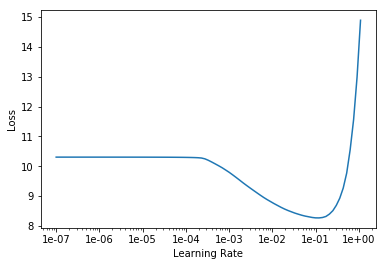

In [13]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,3.447388,3.571142,0.335145,1:14:17
1,3.415538,3.508792,0.338025,1:14:10
2,3.401456,3.496067,0.338629,1:14:16
3,3.259071,3.447059,0.344379,1:14:10
4,3.247761,3.391809,0.349188,1:14:15
5,3.227204,3.323898,0.356667,1:14:13
6,3.209018,3.253901,0.364136,1:14:16
7,3.120736,3.179726,0.373113,1:14:13
8,3.036091,3.123514,0.380693,1:14:12
9,3.050626,3.106447,0.383134,1:14:04


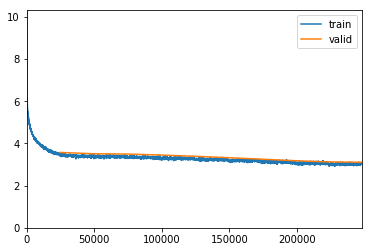

Better model found at epoch 0 with val_loss value: 3.5711421966552734.
Better model found at epoch 1 with val_loss value: 3.50879168510437.
Better model found at epoch 2 with val_loss value: 3.4960672855377197.
Better model found at epoch 3 with val_loss value: 3.447059154510498.
Better model found at epoch 4 with val_loss value: 3.39180850982666.
Better model found at epoch 5 with val_loss value: 3.3238980770111084.
Better model found at epoch 6 with val_loss value: 3.253901243209839.
Better model found at epoch 7 with val_loss value: 3.1797256469726562.
Better model found at epoch 8 with val_loss value: 3.123513698577881.
Better model found at epoch 9 with val_loss value: 3.1064469814300537.


In [14]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7), callbacks=[ShowGraph(learn),  SaveModelCallback(learn, name='wiki-pt-lm-30k-head-best')])

In [ ]:
learn.load("wiki-pt-lm-30k-head-best")

In [17]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,3.023425,3.133007,0.379855,1:13:58
1,3.050706,3.138383,0.378844,1:13:55
2,3.016838,3.122000,0.380999,1:13:56
3,3.023969,3.104743,0.383602,1:13:54
4,2.999915,3.098463,0.384465,1:14:08


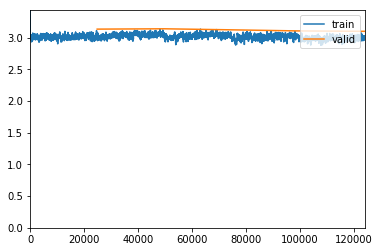

Better model found at epoch 0 with val_loss value: 3.1330065727233887.
Better model found at epoch 2 with val_loss value: 3.1220004558563232.
Better model found at epoch 3 with val_loss value: 3.104743480682373.
Better model found at epoch 4 with val_loss value: 3.098463296890259.


In [18]:
learn.fit_one_cycle(5, 5e-4, moms=(0.8,0.7), callbacks=[ShowGraph(learn),  SaveModelCallback(learn, name='wiki-pt-lm-30k-step3-best')])

In [13]:
np.exp(3.584594)

36.038723026668926

In [ ]:
learn.fit_one_cycle(5, 7e-4, moms=(0.8,0.7), callbacks=[ShowGraph(learn),  SaveModelCallback(learn, name='wiki-pt-lm-30k-step4-best')])

In [20]:
learn.save('wiki_pt_lm_30k_best')

In [19]:
np.exp(3.098463)

22.16385923676989

In [31]:
learn.save_encoder('wiki_pt_lm_30k_encoder')

In [32]:
learn.export('wiki_pt_lm_30k_export')

In [21]:
data_lm.vocab.save(pathlib.Path(f"{DATA_PATH}/wiki_pt_lm_30k_itos_vocab.pkl"))

In [22]:
!cp ../../data/wiki-pt/models/wiki_pt_lm_30k_best.pth ../../data/mercado-livre/models/